# Test downscaling

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_58760\949786954.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


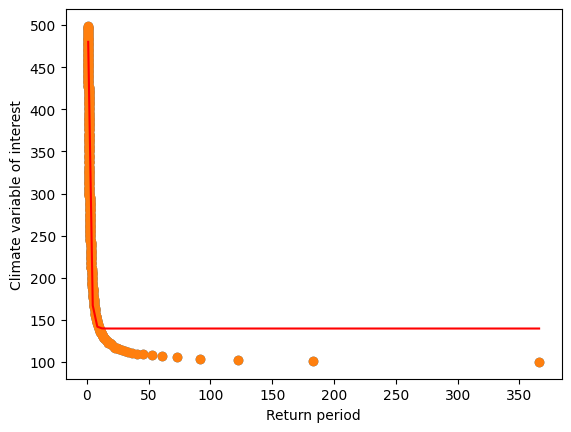

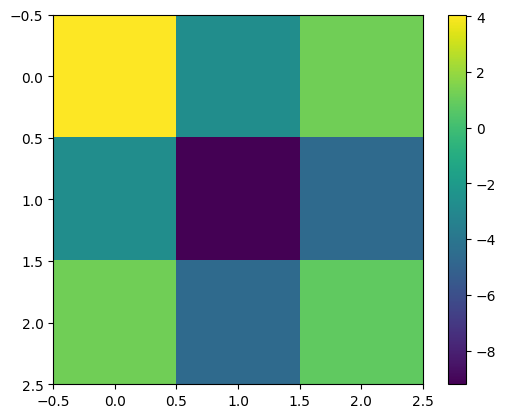

In [1]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)



#### Pointwise models

In [2]:
# importing librairies and setting up
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from utils import get_sample_data

sns.set(style='darkgrid')

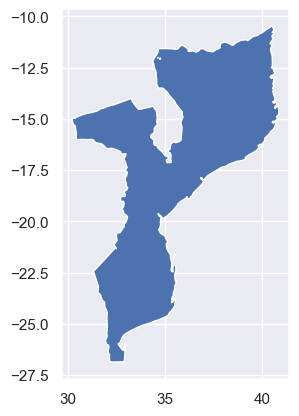

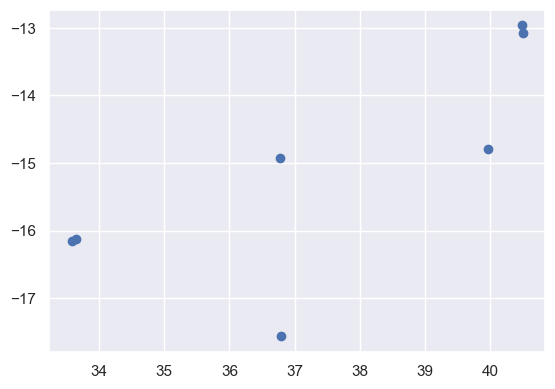

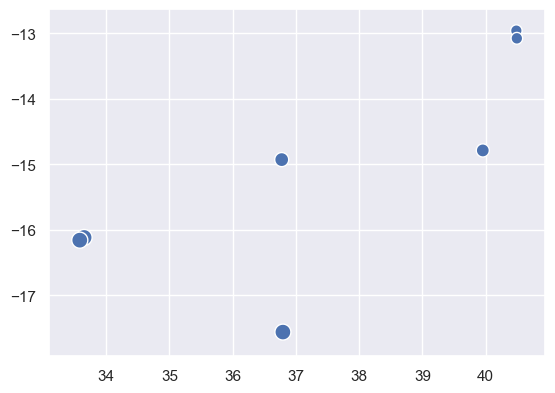

In [3]:
## load project information

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus

### YEAR
first_year = 2025 # start year included
last_year = 2026 # last year included

year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index o dates vector

In [ ]:
# load sample data

# need to change this function
training = get_sample_data('training')
targets = get_sample_data('targets')

# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))

# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['tmax'].plot(ax=axes[0], label='training')
targets[time_slice]['tmax'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Temperature [C]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

In [9]:
# test new functions
from FileManagement import read_nc_file
path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature\Copernicus-CMIP6\daily_maximum_near_surface_air_temperature\PT_Revubue2(Rev201)\historical-1950-2014\monthly\tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19500116-20141216_v20210113.nc'
lat, lon, time, variable = read_nc_file(path)

In [8]:
os.path.isfile(path)

True

In [10]:
lat

array([-16.4912   , -15.78944  , -15.08769  , -14.38594  , -13.68418  ,
       -12.98243  , -12.28068  , -11.57893  , -10.87717  , -10.17542  ,
        -9.473666 ,  -8.771913 ,  -8.07016  ,  -7.368407 ,  -6.666654 ,
        -5.964901 ,  -5.263148 ,  -4.561395 ,  -3.859642 ,  -3.157889 ,
        -2.456136 ,  -1.754383 ,  -1.05263  ,  -0.3508765,   0.3508765,
         1.05263  ,   1.754383 ,   2.456136 ,   3.157889 ,   3.859642 ,
         4.561395 ,   5.263148 ,   5.964901 ,   6.666654 ,   7.368407 ,
         8.07016  ,   8.771913 ,   9.473666 ,  10.17542  ,  10.87717  ,
        11.57893  ,  12.28068  ,  12.98243  ,  13.68418  ,  14.38594  ,
        15.08769  ,  15.78944  ,  16.4912   ,  17.19295  ,  17.8947   ,
        18.59645  ,  19.29821  ,  19.99996  ,  20.70171  ,  21.40347  ,
        22.10522  ,  22.80697  ,  23.50872  ,  24.21048  ,  24.91223  ,
        25.61398  ,  26.31573  ,  27.01749  ,  27.71924  ,  28.42099  ,
        29.12275  ,  29.8245   ,  30.52625  ,  31.228    ,  31.9

In [11]:
Dataset(path)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: standard
    branch_time_in_child: 0.0
    branch_time_in_parent: 0.0
    contact: cmip6-data@ec-earth.org
    creation_date: 2020-12-07T07:15:11Z
    data_specs_version: 01.00.31
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacella
    forcing_index: 1
    frequency: mon
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.EC-Earth-Consortium.EC-Earth3-CC.historical.none.r1i1p1f1
    grid: T255L91
    grid_label: gr
    history: 2020-12-07T07:14:40Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
processed by ece2cmor v1.4.0, git rev. 91c83b029cad779d245d6ce78c004feae130c3a1

    initialization_index: 1
    institution: AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, Denmark; ENEA, Italy; FMI, Finland; Geomar, Germany;

## Downscaling

In [80]:
# Observation data 
# from copernicus CRU, tasmax in degrees Celsius
#obs = Dataset(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Observations\temperature\global\1950-2019\monthly\0_5_x_0_5\cru\v4.03\CRU_maximum_temperature_mon_0.5x0.5_global_1950_v4.03.nc')
path =r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Observations\temperature\global\1950-2019\monthly\0_5_x_0_5\cru\v4.03\CRU_maximum_temperature_mon_0.5x0.5_global_2016_v4.03.nc'

In [81]:
# read data
from FileManagement import read_nc_file
(lat, lon, time, tasmax_obs) = read_nc_file(path)
#obs.variables['tasmax'].values

In [83]:
tasmax_obs[tasmax_obs!=9.96921e+36]

array([ 11.3     ,  11.400001,  11.7     , ..., -25.800001, -25.300001,
       -25.1     ], dtype=float32)

In [84]:
data = Dataset(path)
data.variables['tasmax']._FillValue

9.96921e+36

In [86]:
data.variables['tasmax']

<class 'netCDF4._netCDF4.Variable'>
float32 tasmax(time, lat, lon)
    standard_name: air_temperature
    long_name: maximum monthly near-surface temperature
    units: degrees Celsius
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
    correlation_decay_distance: 1200.0
unlimited dimensions: time
current shape = (12, 360, 720)
filling on

In [87]:
# data to correct
path_train_data=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature\Copernicus-CMIP6\daily_maximum_near_surface_air_temperature\PT_Revubue2(Rev201)\historical-1950-2014\monthly\tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19500116-20141216_v20210113.nc'
(lat_train, lon_train, time_train, tasmax_train)  = read_nc_file(path_train_data)

OSError: [Errno -51] NetCDF: Unknown file format: b'\\\\COWI.net\\projects\\A245000\\A248363\\CRVA\\Datasets\\temperature\\Copernicus-CMIP6\\daily_maximum_near_surface_air_temperature\\PT_Revubue2(Rev201)\\historical-1950-2014\\monthly\\tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19500116-20141216_v20210113.nc'

In [88]:
Dataset(path_train_data)

OSError: [Errno -51] NetCDF: Unknown file format: b'\\\\COWI.net\\projects\\A245000\\A248363\\CRVA\\Datasets\\temperature\\Copernicus-CMIP6\\daily_maximum_near_surface_air_temperature\\PT_Revubue2(Rev201)\\historical-1950-2014\\monthly\\tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19500116-20141216_v20210113.nc'

In [89]:
os.path.isdir(path_train_data)

False

In [14]:
# dans 
# partie 1, BC
# partie 2, downscaling
# ligne les plus importante pour downscaling 

# on les donnees, on peut y aller. obs ceux de l'exemple ou bien copernicus. a corriger temp CMIP6 
from skdownscale.pointwise_models import PointWiseDownscaler # importation fonctionne
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation # importation fonctionne
#from dask.diagnostics import ProgressBar

model = PointWiseDownscaler(BcsdTemperature(return_anoms=False)) # fonctioonne
#model
model.fit(train_subset, obs_subset) # train subset and obs_subset are xarray.DataArray 'tasmax'
display(model, model._models)

In [15]:
import intake_esm
intake_esm.__version__

'2023.4.20'

In [17]:
import intake

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(train_subset)
train_subset.isel(time=0).plot()

ESMDataSourceError: Failed to load dataset with key='CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'
                 You can use `cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].df` to inspect the assets/files for this key.
                 